# COMP5318: Assignment 1
## By SID 500525438

In [1]:
# Library imports

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime

In [2]:
# Loading our training data

with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
    
# Loading our testing data

with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [3]:
# Verifying our loaded training data
print(data_train.shape, label_train.shape)

# Verifying our loaded testing data
print(data_test.shape, label_test.shape)

(30000, 784) (30000,)
(5000, 784) (2000,)


In [4]:
# Class mappings
class_mappings = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [5]:
current_image = 1

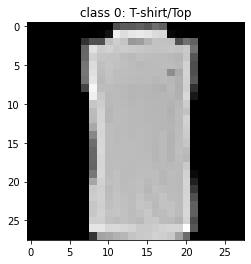

In [6]:
# Testing loading an image

data_train = data_train.reshape((data_train.shape[0], 28, 28))
plt.imshow(data_train[current_image], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[current_image]) + ": " + class_mappings[label_train[current_image]] )
plt.show()

### Utilities

In [7]:
def calc_top1_accuracy(predicted, actual):
    '''
    Calculates the top-1 accuracy metric, given the predicted classes against the actual classes
    INPUT: 1D array of predicted results,
        1D array of actual results
    OUTPUT: percentage in decimal format of accuracy    
    '''
    correct = 0
    for n in range(actual.shape[0]):
        if predicted[n] == actual[n]:
            correct += 1
        
    return correct/actual.shape[0]

### Pre-processing

#### PCA

In [8]:
def apply_pca(data_train, data_test, n_components=20):
    '''
    Apply PCA on the given dataset
    INPUT: 2D or 3D array dataset
    OUTPUT: 2D array of dataset reduced to n dimensions
    '''
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))
    
    # Need to get the mean of each feature, for mean normalisation/centreing
    data_train_mean = data_train.mean(axis=0)
    data_test_mean = data_test.mean(axis=0)
    # Feature means should now be zero, or approx. close to zero - and hence centred
    data_train_centred = np.subtract(data_train, data_train_mean)
    data_test_centred = np.subtract(data_test, data_test_mean)
    
    # Checking the following, we can see that the max and min value of the entire matrix is 0 and 1
    # hence scaling is not required
    '''
    print(data_train.min())
    print(data_train.max())
    print(data_test.min())
    print(data_test.max())
    '''
    
    covariance_matrix = (data_train_centred.T).dot(data_train_centred)
    l, V = np.linalg.eig(covariance_matrix)
    
    sorted_lambda_index =  l.argsort()[::-1] # sorting our lambda values from largest to smallest
    
    V_n = V[:,sorted_lambda_index[:n_components]]
    
    # Do the projection of the image matrix against our orthogonal eigenvector matrix reduced to n columns
    pca_data_train = data_train_centred.dot(V_n)
    pca_data_test = data_test_centred.dot(V_n)
    
    return (pca_data_train, pca_data_test)

#### SVD

In [9]:
def apply_svd(data_train, data_test, n_components=False):
    '''
    Apply Singular Value Decomposition for a given training dataset,
    and subsequently apply our test dataset onto the same orthognal V
    '''
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))
        
    U, s, Vt = np.linalg.svd(data_train, full_matrices=False)
    
    # Since our singular values in array s are already sorted from largest to smallest, we can then remove
    # the insignificant singular values, and also remove the affected rows & columns from U and Vt
    # However, since we'll only use Vt, then we only apply it there
    if n_components:
        Vt = Vt[:n_components, :]
    
    # We do dot product between our data matrix and Vt.T because Vt is already reduced to the orthonormal vectors
    # which have the highest singular value scores.  Moreover, we need to transpose Vt in order to do dot product
    # with our data matrix (data_train and/or data_test)
    svd_data_train = data_train.dot(Vt.T)
    svd_data_test = data_test.dot(Vt.T)
    
    return (svd_data_train, svd_data_test)

### Classification Algorithms

#### k-Nearest Neighbours

In [10]:
def knn(data_train, label_train, data_test, K=3):
    '''
    k-Nearest Neighbour classifier
    INPUT: 2D/3D array of training dataset (data_train),
        1D array of label of training dataset (label_train),
        2D/3D array of the dataset to be predicted (data_test),
        (optional) K number of nearest neighbours
    OUTPUT: 1D array of predicted results with the same length as data_test.shape[0]
    '''
    
    # Reshaping our input data, to ensure it's 2D
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))
        
    # Instantiating our empty array for predicted values
    pred_test = np.zeros(data_test.shape[0])
    
    for image_num in range(data_test.shape[0]):
        # Calculating the distance difference between the test subject and all our training points
        sum_sqrd_distances = np.sqrt((np.square(np.subtract(data_train, data_test[image_num]))).sum(axis=1))
        #sum_sqrd_distances = np.linalg.norm(data_train - data_test[image_num], axis=1)
    
        # Getting the k nearest neighbours
        k_nearest_neighbours = (np.argsort(sum_sqrd_distances))[:K]
    
        classes_dict = {}

        # Using weighted distance, instead of simply using count
        for neighbour_idx in k_nearest_neighbours:
            classification = label_train[neighbour_idx]
            if classification in classes_dict:
                classes_dict[classification] += 1/(sum_sqrd_distances[neighbour_idx]**2)
            else:
                classes_dict[classification] = 1/(sum_sqrd_distances[neighbour_idx]**2)
            
        pred_class = None
        for key in classes_dict:
            if pred_class == None:
                pred_class = key
                continue

            if classes_dict[key] > classes_dict[pred_class]:
                pred_class = key
                
        pred_test[image_num] = pred_class
            
    return pred_test

In [11]:
# k-Nearest Neighbours Classifier using raw data as input
print(f"Started at: {datetime.now()}")
knn_results = knn(data_train, label_train, data_test, K=5)
print(f"Finished at: {datetime.now()}")
accuracy = calc_top1_accuracy(knn_results, label_test)
print(f"Accuracy result for kNN (raw) is: {accuracy}")

# k-Nearest Neighbours Classifier with PCA
print(f"Started at: {datetime.now()}")
pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components=50)
knn_pca_results = knn(pca_data_train, label_train, pca_data_test, K=5)
print(f"Finished at: {datetime.now()}")
accuracy = calc_top1_accuracy(knn_pca_results, label_test)
print(f"Accuracy result for kNN (PCA) is: {accuracy}")

# k-Nearest Neighbours Classifier with SVD
print(f"Started at: {datetime.now()}")
svd_data_train, svd_data_test = apply_svd(data_train, data_test, n_components=50)
knn_svd_results = knn(svd_data_train, label_train, svd_data_test, K=5)
print(f"Finished at: {datetime.now()}")
accuracy = calc_top1_accuracy(knn_svd_results, label_test)
print(f"Accuracy result for kNN (SVD) is: {accuracy}")

Started at: 2020-10-14 13:51:57.903713
Finished at: 2020-10-14 14:01:43.121852
Accuracy result for kNN (raw) is: 0.8275
Started at: 2020-10-14 14:01:43.121852
Finished at: 2020-10-14 14:02:30.757156
Accuracy result for kNN (PCA) is: 0.8365
Started at: 2020-10-14 14:02:30.757156
Finished at: 2020-10-14 14:03:22.030093
Accuracy result for kNN (SVD) is: 0.8375


#### Naive Bayes

In [12]:
def gaussian_naive_bayes(data_train, label_train, data_test):
    '''
    Gaussian Naive Bayes classifier
    INPUT: 2D/3D array of training dataset (data_train),
        1D array of label on training dataset (label_train),
        2D/3D array of test dataset (data_test)
    OUTPUT: 1D array of predicted classes on test dataset
    '''
    
    # Reshaping if it's not the expected shape (2D)
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))

    # Obtaining the different classes that we have present in our training data and getting index positions of each one
    class_indices = {}
    for idx, image_class in enumerate(label_train):
        if image_class not in class_indices:
            class_indices[image_class] = [idx]
            continue
        else:
            class_indices[image_class].append(idx)
        
    class_mean = {}
    class_var = {}

    # Obtain the mean and std dev for each class of our training data
    for class_index in class_indices:
        class_mean[class_index] = data_train[class_indices[class_index], :].mean(axis=0)
        class_var[class_index] = data_train[class_indices[class_index], :].var(axis=0)

    pred_test = np.zeros(data_test.shape[0])

    for image_num in range(data_test.shape[0]):
        # In order to find the length of pred_class_scores, we need to get the max value of the keys
        # with the assumption that each number up to the max will be a class
        # we do this instead of length because our training data may not have an entry for a class, hence, it'll
        # result in out of range if a data exists for one higher
        pred_class_scores = np.zeros(max(class_indices, key=int)+1)
        
        for class_index in class_indices:
            
            # Calculating the logged prior probability
            class_prob = np.log(len(class_indices[class_index])/data_train.shape[0])

            # Calculating the sum of the logged conditional probability
            likelihood_array = st.norm.logpdf(x=data_test[image_num], loc=class_mean[class_index], scale=np.sqrt(class_var[class_index]))
            class_prob = class_prob + np.nansum(likelihood_array) # we use nansum to avoid nan likelihoods, because these are obtained from points with zero variance

            # Storing the result in our results array, so we can keep track of which class has the highest
            pred_class_scores[class_index] = class_prob

        # Class with the highest prob is the predicted class for the image, which is stored in our final pred_test array
        pred_test[image_num] = np.nanargmax(pred_class_scores)
        
    return pred_test

In [13]:
# Gaussian Naive Bayes using raw data as input
print(f"Started at: {datetime.now()}")
nb_results = gaussian_naive_bayes(data_train, label_train, data_test)
print(f"Finished at: {datetime.now()}")
accuracy = calc_top1_accuracy(nb_results, label_test)
print(f"Accuracy result for NB (raw) is: {accuracy}")

# Gaussian Naive Bayes applied on principal components of dataset
print(f"Started at: {datetime.now()}")
pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components=80)
nb_pca_results = gaussian_naive_bayes(pca_data_train, label_train, pca_data_test)
print(f"Finished at: {datetime.now()}")
accuracy = calc_top1_accuracy(nb_pca_results, label_test)        
print(f"Accuracy result for NB (PCA) is: {accuracy}")

# Gaussian Naive Bayes applied on SVD of dataset
print(f"Started at: {datetime.now()}")
svd_data_train, svd_data_test = apply_svd(data_train, data_test, n_components=80)
nb_svd_results = gaussian_naive_bayes(svd_data_train, label_train, svd_data_test)
print(f"Finished at: {datetime.now()}")
accuracy = calc_top1_accuracy(nb_svd_results, label_test)
print(f"Accuracy result for kNN (SVD) is: {accuracy}")

Started at: 2020-10-14 14:03:22.117095


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1782: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Finished at: 2020-10-14 14:03:36.962230
Accuracy result for NB (raw) is: 0.655
Started at: 2020-10-14 14:03:36.979353
Finished at: 2020-10-14 14:03:48.552767
Accuracy result for NB (PCA) is: 0.757
Started at: 2020-10-14 14:03:48.552767
Finished at: 2020-10-14 14:04:03.970988
Accuracy result for kNN (SVD) is: 0.7575
